### Entangling gate on two coupled qubits

#### Imports

In [1]:
!pip install -q -U pip
!pip install -q matplotlib

In [2]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from typing import List

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils

2021-12-08 12:26:53.528802: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 12:26:53.528832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Model components
The model consists of two qubits with 3 levels each and slightly different parameters:

In [3]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(value=freq_q1, min_val=4.995e9, max_val=5.005e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q1, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q1, min_val=1e-6, max_val=90e-6, unit='s'),
    t2star=Qty(value=t2star_q1, min_val=10e-6, max_val=90e-3, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

freq_q2 = 5.6e9
anhar_q2 = -240e6
t1_q2 = 23e-6
t2star_q2 = 31e-6
q2 = chip.Qubit(
    name="Q2",
    desc="Qubit 2",
    freq=Qty(value=freq_q2, min_val=5.595e9, max_val=5.605e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q2, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q2, min_val=1e-6, max_val=90e-6,unit='s'),
    t2star=Qty(value=t2star_q2, min_val=10e-6, max_val=90e-6, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

2021-12-08 12:26:55.601657: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-08 12:26:55.601864: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 12:26:55.601877: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 12:26:55.601899: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2021-12-08 12:26:55.602374: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


There is a static coupling in x-direction between them: $(b_1+b_1^\dagger)(b_2+b_2^\dagger)$

In [4]:
coupling_strength = 50e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

and each qubit has a drive line

In [5]:
drive1 = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.x_drive
)

All parts are collected in the model. The initial state will be thermal at a non-vanishing temperature.

In [6]:
init_temp = 50e-3
init_ground = tasks.InitialiseGround(
    init_temp=Qty(value=init_temp, min_val=-0.001, max_val=0.22, unit='K')
)

model = Mdl(
    [q1, q2], # Individual, self-contained components
    [drive1, drive2, q1q2],  # Interactions between components
    [init_ground] # SPAM processing
)
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals
The devices for the control line are set up

In [7]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
v2hz = 1e9

lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')
resp = devices.Response(
    name='resp',
    rise_time=Qty(value=0.3e-9, min_val=0.05e-9, max_val=0.6e-9, unit='s'),
    resolution=sim_res
)
dig_to_an = devices.DigitalToAnalog(name="dac", resolution=sim_res)
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(value=v2hz, min_val=0.9e9, max_val=1.1e9, unit='Hz/V')
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [8]:
generator = Gnr(
        devices={
            "LO": lo,
            "AWG": awg,
            "DigitalToAnalog": dig_to_an,
            "Response": resp,
            "Mixer": mixer,
            "VoltsToHertz": v_to_hz
        },
        chains={
            "d1": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"],
            },
            "d2": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Response": ["DigitalToAnalog"],
                "Mixer": ["LO", "Response"],
                "VoltsToHertz": ["Mixer"],
            }
        }
    )

#### Gates-set and Parameter map
Following a general cross resonance scheme, both qubits will be resonantly driven at the frequency of qubit 2 with a Gaussian envelope. We drive qubit 1 (the control) at the frequency of qubit 2 (the target) with a higher amplitude to compensate for the reduced Rabi frequency.

In [9]:
t_final = 45e-9
sideband = 50e6
gauss_params_single_1 = {
    'amp': Qty(value=0.8, min_val=0.2, max_val=3, unit="V"),
    't_final': Qty(value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"),
    'sigma': Qty(value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"),
    'xy_angle': Qty(value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit='rad'),
    'freq_offset': Qty(value=-sideband - 3e6, min_val=-56 * 1e6, max_val=-52 * 1e6, unit='Hz 2pi'),
    'delta': Qty(value=-1, min_val=-5, max_val=3, unit="")
}

gauss_params_single_2 = {
    'amp': Qty(value=0.03, min_val=0.02, max_val=0.6, unit="V"),
    't_final': Qty(value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"),
    'sigma': Qty(value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"),
    'xy_angle': Qty(value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit='rad'),
    'freq_offset': Qty(value=-sideband - 3e6, min_val=-56 * 1e6, max_val=-52 * 1e6, unit='Hz 2pi'),
    'delta': Qty(value=-1, min_val=-5, max_val=3, unit="")
}

gauss_env_single_1 = pulse.Envelope(
    name="gauss1",
    desc="Gaussian envelope on drive 1",
    params=gauss_params_single_1,
    shape=envelopes.gaussian_nonorm
)
gauss_env_single_2 = pulse.Envelope(
    name="gauss2",
    desc="Gaussian envelope on drive 2",
    params=gauss_params_single_2,
    shape=envelopes.gaussian_nonorm
)

The carrier signal of each drive is set to the resonance frequency
of the target qubit.

In [10]:
lo_freq_q1 = freq_q1 + sideband
lo_freq_q2 = freq_q2 + sideband

carr_1 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

carr_2 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 2",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

#### Instructions
The instruction to be optimised is a CNOT gates controlled by qubit 1.

In [11]:
# CNOT comtrolled by qubit 1
cnot12 = gates.Instruction(
    name="cnot12", targets=[0, 1], t_start=0.0, t_end=t_final, channels=["d1", "d2"],
    ideal=np.array([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,0,1],
        [0,0,1,0]
    ])
)
cnot12.add_component(gauss_env_single_1, "d1")
cnot12.add_component(carr_1, "d1")
cnot12.add_component(gauss_env_single_2, "d2")
cnot12.add_component(carr_2, "d2")
cnot12.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) * 2 * np.pi % (2 * np.pi)
)

#### The experiment
All components are collected in the parameter map and the experiment is set up.

In [12]:
parameter_map = PMap(instructions=[cnot12], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

Calculate and print the propagator before the optimisation.

In [13]:
unitaries = exp.compute_propagators()
print(unitaries[cnot12.get_key()])

2021-12-08 12:27:01.534483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-08 12:27:01.551557: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793495000 Hz


tf.Tensor(
[[ 5.38699071e-01-7.17750563e-02j -8.34752005e-01+8.73275022e-02j
  -6.95346256e-03-2.15875540e-03j -4.35619589e-03+3.35449682e-03j
  -1.06942994e-02+4.11831376e-03j -6.46672021e-05-3.73989900e-05j
  -1.67838080e-04-2.08026492e-04j -6.43312053e-05-7.70584828e-07j
  -3.76227149e-07-6.49845314e-07j]
 [-8.22954017e-01+1.64865789e-01j -5.35373070e-01+9.17248769e-02j
  -7.01716357e-03+7.68563193e-03j -1.04194796e-02+4.75452421e-03j
  -1.61239175e-02-5.34774092e-03j -2.42060738e-04-1.19946128e-05j
   3.81855912e-05+8.66289943e-06j -1.30621879e-04-2.10380577e-04j
  -8.82654253e-07-1.33276919e-06j]
 [-7.61570279e-03+7.68089055e-04j -4.61417534e-03+9.02462832e-03j
   3.59132066e-01-9.32828470e-01j -9.10153028e-05-6.83262609e-05j
  -2.24711912e-04+8.79671466e-05j  2.62921224e-02-1.48696337e-03j
  -4.75883791e-04-4.20508543e-05j  3.46114778e-05+1.64470496e-04j
   2.10121296e-04+1.48066297e-04j]
 [ 4.65531318e-03-6.63491197e-05j  8.62792565e-03+8.22022317e-03j
  -5.58701973e-05+1.086660

#### Dynamics

The system is initialised in the state $|0,1\rangle$ so that a transition to $|1,1\rangle$ should be visible.

In [14]:
psi_init = [[0] * 9]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

tf.Tensor(
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(9, 1), dtype=complex128)


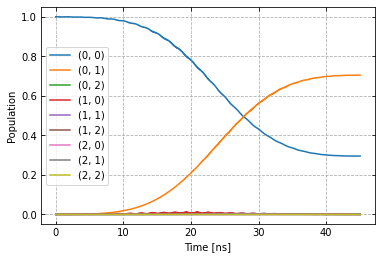

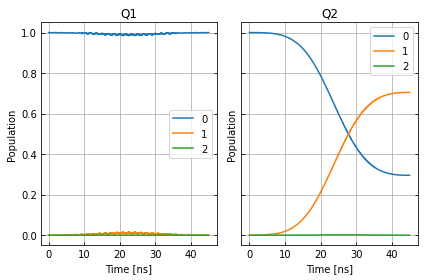

In [15]:
def plot_dynamics(exp, psi_init, seq):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        """
        model = exp.pmap.model
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

def getQubitsPopulation(population: np.array, dims: List[int]) -> np.array:
    """
    Splits the population of all levels of a system into the populations of levels per subsystem.
    Parameters
    ----------
    population: np.array
        The time dependent population of each energy level. First dimension: level index, second dimension: time.
    dims: List[int]
        The number of levels for each subsystem.
    Returns
    -------
    np.array
        The time-dependent population of energy levels for each subsystem. First dimension: subsystem index, second
        dimension: level index, third dimension: time.
    """
    numQubits = len(dims)

    # create a list of all levels
    qubit_levels = []
    for dim in dims:
        qubit_levels.append(list(range(dim)))
    combined_levels = list(itertools.product(*qubit_levels))

    # calculate populations
    qubitsPopulations = np.zeros((numQubits, dims[0], population.shape[1]))
    for idx, levels in enumerate(combined_levels):
        for i in range(numQubits):
            qubitsPopulations[i, levels[i]] += population[idx]
    return qubitsPopulations

def plotSplittedPopulation(
    exp: Exp,
    psi_init: tf.Tensor,
    sequence: List[str]
) -> None:
    """
    Plots time dependent populations for multiple qubits in separate plots.
    Parameters
    ----------
    exp: Experiment
        The experiment containing the model and propagators
    psi_init: np.array
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state
    -------
    """
    # calculate the time dependent level population
    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = np.matmul(du, psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)
    dims = [s.hilbert_dim for s in model.subsystems.values()]
    splitted = getQubitsPopulation(pop_t, dims)

    # timestamps
    dt = exp.ts[1] - exp.ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])

    # create both subplots
    titles = list(exp.pmap.model.subsystems.keys())
    fig, axs = plt.subplots(1, len(splitted), sharey="all")
    for idx, ax in enumerate(axs):
        ax.plot(ts / 1e-9, splitted[idx].T)
        ax.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Population")
        ax.set_title(titles[idx])
        ax.legend([str(x) for x in np.arange(dims[idx])])
        ax.grid()

    plt.tight_layout()
    plt.show()

sequence = [cnot12.get_key()]
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

#### Open-loop optimal control

Now, open-loop optimisation with DRAG enabled is set up.

In [16]:
generator.devices['AWG'].enable_drag_2()

opt_gates = [cnot12.get_key()]
exp.set_opt_gates(opt_gates)

gateset_opt_map=[
    [(cnot12.get_key(), "d1", "gauss1", "amp")],
    [(cnot12.get_key(), "d1", "gauss1", "freq_offset")],
    [(cnot12.get_key(), "d1", "gauss1", "xy_angle")],
    [(cnot12.get_key(), "d1", "gauss1", "delta")],
    [(cnot12.get_key(), "d1", "carrier", "framechange")],
    [(cnot12.get_key(), "d2", "gauss2", "amp")],
    [(cnot12.get_key(), "d2", "gauss2", "freq_offset")],
    [(cnot12.get_key(), "d2", "gauss2", "xy_angle")],
    [(cnot12.get_key(), "d2", "gauss2", "delta")],
    [(cnot12.get_key(), "d2", "carrier", "framechange")]
]
parameter_map.set_opt_map(gateset_opt_map)

parameter_map.print_parameters()

cnot12[0, 1]-d1-gauss1-amp            : 800.000 mV 
cnot12[0, 1]-d1-gauss1-freq_offset    : -53.000 MHz 2pi 
cnot12[0, 1]-d1-gauss1-xy_angle       : -444.089 arad 
cnot12[0, 1]-d1-gauss1-delta          : -1.000  
cnot12[0, 1]-d1-carrier-framechange   : 4.712 rad 
cnot12[0, 1]-d2-gauss2-amp            : 30.000 mV 
cnot12[0, 1]-d2-gauss2-freq_offset    : -53.000 MHz 2pi 
cnot12[0, 1]-d2-gauss2-xy_angle       : -444.089 arad 
cnot12[0, 1]-d2-gauss2-delta          : -1.000  
cnot12[0, 1]-d2-carrier-framechange   : 0.000 rad 



As a fidelity function we choose unitary fidelity as well as LBFG-S (a wrapper of the scipy implementation) from our library.

In [17]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl

log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")
opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={
        "maxfun": 25
    },
    run_name="cnot12"
)

Start the optimisation

In [18]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)
opt.optimize_controls()

C3:STATUS:Saving as: /tmp/tmpjx66lyg2/c3logs/cnot12/2021_12_08_T_12_27_05/open_loop.log
1 0.8790556354859858
2 0.9673489008768812
3 0.758622722337525
4 0.7679637459613755
5 0.6962301452070802
6 0.541321232138175
7 0.5682335581707882
8 0.382921410272719
9 0.43114251105289114
10 0.30099424375388173
11 0.32449492775751976
12 0.26537726105532744
13 0.2653362073570743
14 0.25121669688810866
15 0.23925168937407626
16 0.18551042816386099
17 0.1305543307431979
18 0.07413739981051659
19 0.031551815290153495
20 0.017447484467834062
21 0.007924221221055072
22 0.006483318391815374
23 0.005732979353259449
24 0.005594385264244273
25 0.0055582927728303755
26 0.005521343169743842


The final parameters and the fidelity are

In [19]:
parameter_map.print_parameters()
print(opt.current_best_goal)

cnot12[0, 1]-d1-gauss1-amp            : 2.359 V 
cnot12[0, 1]-d1-gauss1-freq_offset    : -53.252 MHz 2pi 
cnot12[0, 1]-d1-gauss1-xy_angle       : 587.818 mrad 
cnot12[0, 1]-d1-gauss1-delta          : -743.473 m 
cnot12[0, 1]-d1-carrier-framechange   : -815.216 mrad 
cnot12[0, 1]-d2-gauss2-amp            : 56.719 mV 
cnot12[0, 1]-d2-gauss2-freq_offset    : -53.176 MHz 2pi 
cnot12[0, 1]-d2-gauss2-xy_angle       : -135.515 mrad 
cnot12[0, 1]-d2-gauss2-delta          : -519.864 m 
cnot12[0, 1]-d2-carrier-framechange   : 598.919 mrad 

0.005521343169743842


#### Results of the optimisation
Plotting the dynamics with the same initial state:

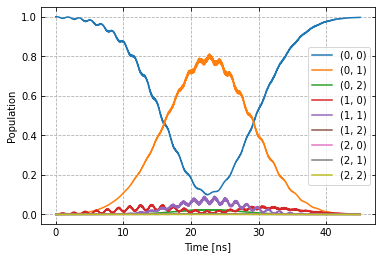

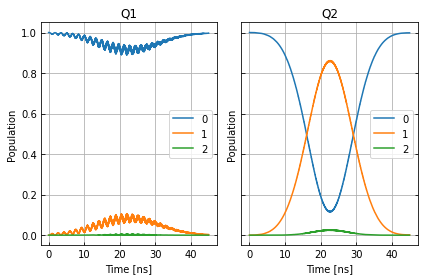

In [20]:
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

Now we plot the dynamics for the control in the excited state.

tf.Tensor(
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(9, 1), dtype=complex128)


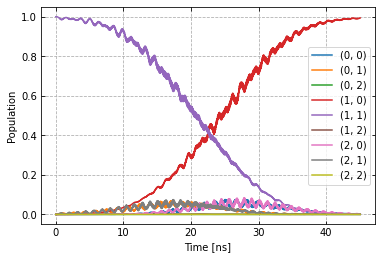

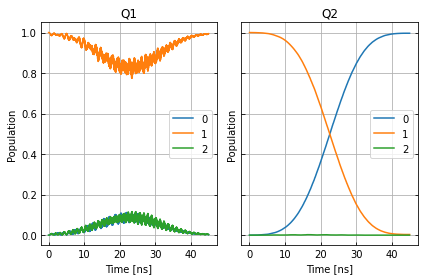

In [23]:
psi_init = [[0] * 9]
psi_init[0][4] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

As intended, the dynamics of the target is dependent on the control qubit performing a flip if the control is excited and an identity otherwise.